## Linear + Softmax Classifier + Stochastic Gradient Descent (SGD) Lab

Here we will implement a linear classifier using a softmax function and negative log likelihood loss. These terms will be more clear as we finish this lecture. The idea is that you will learn these concepts by attending lectures, doing background reading, and completing this lab. Pytorch contains a powerful set of libraries for training complex machine learning and deep learning models but for this lab we will also be implementing things from zero.

### 1. First let's load some training data. 
We will be using the CIFAR-10 dataset. CIFAR-10 is a dataset consisting of 50k training images belonging to 10 categories. A validation set is also provided which contains 10k images. The images are rescaled to a size of 32x32 pixels. This is a relatively small dataset that can be loaded entirely in memory so it is very convenient to experiment with. You will probably read several papers reporting results on this dataset during this class but most state-of-the-art methods usually try experiments in much larger datasets with millions of images. You need to be more clever about dataloading and reading in those cases but pytorch offers parallel data loaders and other useful tools for those cases.

Pytorch already has a Dataset class for CIFAR10 so we just have to learn to use it. You should also check the ImageFolder data loader which could be useful for some of your projects. You should also learn to create your own Dataset classes by inheriting from torch.utils.data.Dataset. You only have to implement two functionalities: \__getitem\__ and \__len\__. Pytorch is opensource so you can check the code for other Dataset classes including CIFAR10: https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

Files already downloaded and verified

The training data has 50000 samples
Image 0 is a frog


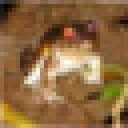

In [1]:
import torch, torchvision, PIL
from torchvision.datasets import CIFAR10 
from PIL import Image
import numpy as np
from io import BytesIO
import torchvision.transforms as transforms
import IPython.display
import lab_utils # Stuff from previous labs.
from lab_utils import pil2tensor, tensor2pil
%load_ext autoreload
%autoreload 2

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
class2id = {name: idx for (idx, name) in enumerate(classes)}
trainset = CIFAR10(root='./data', train = True, download = True)

# Datasets need to implement the __len__ method.
print('\nThe training data has %d samples' % len(trainset))

# Datasets need to implement the __getitem__ method.
image_index = 0
img, label = trainset[image_index]
print('Image %d is a %s' % (image_index, classes[label]));
lab_utils.show_image(img.resize((128, 128)));  # Make bigger to visualize.

Let's show a group of images from the dataset to have a better idea of what the images look like.

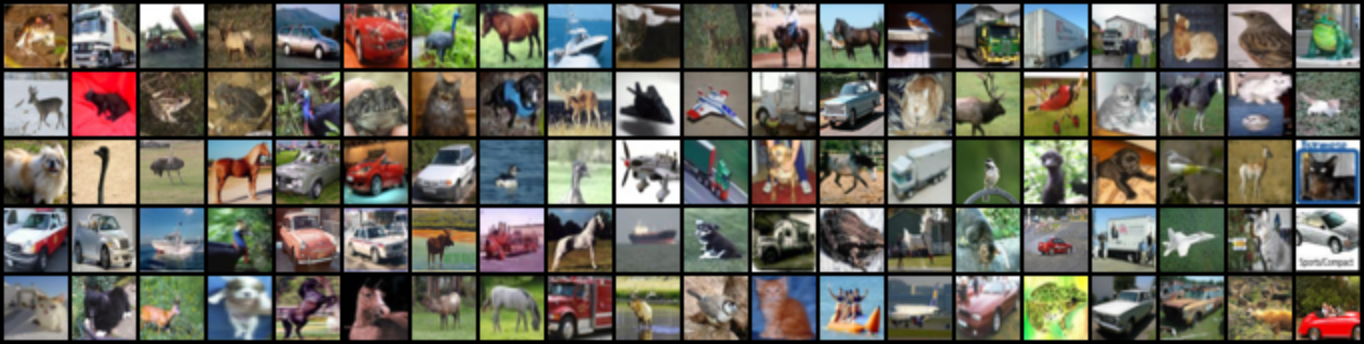

In [2]:
sample_imgs = list()
for i in range(0, 100):
    img, _ = trainset[i]  # We don't do anything with the labels so we just use underscore _
    sample_imgs.append(img)
    
# Lots of hacks to show a list of PIL images as a grid of images.
def show_images(images, zoom = 1.0, ncols = 10):
    imgs = images if type(images[0]) == torch.Tensor else [pil2tensor(img) for img in images]
    grid = torchvision.utils.make_grid(imgs, nrow = ncols)
    pil_image = Image.fromarray(np.transpose(grid.mul(255).byte().numpy(), (1, 2, 0)))
    target_size = (int(zoom * pil_image.width), int(zoom * pil_image.height))
    pil_image = pil_image.resize(target_size, resample = PIL.Image.BILINEAR)
    bio = BytesIO(); pil_image.save(bio, format = 'png')
    IPython.display.display(IPython.display.Image(bio.getvalue()))

# Show images below at 2.0x zoom level. Remember they are 32x32 pixels only.
show_images(sample_imgs, zoom = 2.0, ncols = 20)

Let's make sure our train loaders transform the input image into a tensor.

In [3]:
imgTransform = transforms.Compose([
    transforms.ToTensor()
])

trainset = CIFAR10(root='./data', train = True, transform = imgTransform)
valset = CIFAR10(root='./data', train = False, transform = imgTransform)

### 2. Computing a linear sofmax classifier "forward" pass.
The classifier will take as input vectors of size 3x32x32 = 3072, which is the size of the images. The classifier will output vector predictions of size 10, where each entry corresponds to a category. The function representing the linear classifier is:  

$$\hat{y} = softmax(Wx+b)$$

where the $softmax$ function is applied to each element in the vector $a = Wx + b$. The weight matrix $W$ is of size 10x3072, and $b$ is a bias vector of size 10, so the output vector $a$ is of size 10 to match the number of categories that we want to predict. Both $W$ and $b$ need to be learned using the training data. The softmax function is defined for each entry $a_i$ in the vector $a$ as:

$$\hat{y}_i = softmax(a_i) = \frac{exp(a_i)}{\sum_{k=1}^{10}{exp(a_k)}}$$

The softmax function forces the entries in the vector $\hat{y}$ to sum to 1. We will discuss in the next section and during class in more detail why this transformation is convenient.


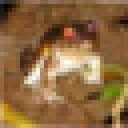

Image predicted as horse with confidence 0.15


In [4]:
# Softmax function: exp(a) / sum(exp(a))
# Note that this function works for tensors of any shape, it is not a scalar function.
def softmax(a):
    max_val = a.max()  # This is to avoid variable overflows.
    exp_a = (a - max_val).exp()
    return exp_a.div(exp_a.sum())

# Classification function: y = softmax(Wx + b)
# Again, note this function is operating on vectors.
def linear(x, weight, bias):
    return torch.matmul(weight, x) + bias

# Initialize bias and weight with random values.
weight = torch.Tensor(10, 3 * 32 * 32).normal_(0, 0.01)
bias = torch.Tensor(10, 1).normal_(0, 0.01)

# Now predict the category using this un-trained classifier.
img, _ = trainset[0]
x = img.view(3 * 32 * 32, 1)
a = linear(x, weight, bias)
predictions = softmax(a)

# Show the results of the classifier.
lab_utils.show_image(tensor2pil(img).resize((128, 128)));
max_score, max_label = predictions.max(0)
print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

Now we have a working classifier but it is not a very good one. The rest of this lab will deal with "training" or "learning" the weight and bias parameters that minimize the number of errors of the classifier in the training data. Under certain conditions the parameters learned in the training data will also be generally good to make predictions on other data not seen during training. This property is called generalization. We will discuss in class more about those concepts.  

### 3. Computing the loss function (also referred to as criterion in pytorch)
The first step to train our weight and bias parameters is to define a criterion for how wrong (or good) are the predictions given a weight and bias parameters. Loss functions measure the "distance" between a prediction $\hat{y}$ and a true label $y$. In the case of softmax, you can think of your true label $frog$ as a vector with all zeros except in the frog entry where it is one, e.g. $y = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]$. The loss function $\ell(y,\hat{y})$ between the prediction and true label is given then simply by the following equation: 
$$\ell(y, \hat{y})= -\sum_iy_ilog(\hat{y}_i)$$

Since the true label vector $y$ only has one non-zero entry, we know this sum really has only one term that is non-zero so you will usually see this loss function simply stated as:

$$\ell(label, \hat{y}) = -log(\hat{y}_{label})$$

The intuition behind this loss function is that we want the prediction score corresponding to the true label to be as high as possible (close to one), and by doing this we will also push the other scores to go close to zero because the softmax function forces these scores to sum to one. Since we want to pose the problem as a minimization problem, we use $-log(y_{label})$. (There are probabilistic and information theory interpretations of this loss but we will not analyze them for the purpose of this class)

In [5]:
def loss(label, predictions):
    return -predictions[label].log()

# Let's compute predictions again.
predictions = softmax(linear(x, weight, bias))

for (i, pred) in enumerate(predictions.squeeze().tolist()):
    print('y_hat[%s] = %.2f' % (classes[i], pred))

# The correct label for this image is 'frog'.
loss_value = loss(class2id['frog'], predictions)
print('\nLoss: %.2f' % loss_value[0])

y_hat[airplane] = 0.08
y_hat[automobile] = 0.10
y_hat[bird] = 0.12
y_hat[cat] = 0.12
y_hat[deer] = 0.08
y_hat[dog] = 0.11
y_hat[frog] = 0.11
y_hat[horse] = 0.15
y_hat[ship] = 0.08
y_hat[truck] = 0.06

Loss: 2.24


### 4. Computing Numerical Gradients for parameters $W$ and $b$
The rest of this lab will be about modifying the parameters $W$ and $b$ so that the loss for all the images in the training set is as small as possible. Randomly modifying the values of these parameters until finding a set of values for which the loss becomes smaller might work reasonably well when few parameters need to be estimated but our weight matrix $W$ alone has 3072x10 = 30720 parameters, and some models that we will study later in the class have billions of parameters.

We will instead use Stochastic Gradient Descent (SGD), which is an optimization technique that consists on computing the loss for a training sample or a small group of training samples and modifying the parameters $W$ and $b$ by shifting them a small amount in the direction of their gradients, we will go over this in more detail later. We will first focus on how to compute those gradients, particularly $\frac{\partial \ell}{\partial w_{ij}}$ and $\frac{\partial \ell}{\partial b_i}$. 

A simple yet effective first approach is to compute the gradients with a numerical approximation using the definition of derivatives: $$f'(x) = lim_{h\rightarrow0}\frac{f(x + h) - f(x - h)}{2h}$$. For a given single input pair $(x, y)$ the output of the loss function $\ell$ just depends on the parameters $W$ and $b$. Taken this into account, for each entry $w_{ij}$ in the weight matrix $W$ we are interested in the following:

$$\frac{\partial \ell(W,b)}{\partial w_{ij}} = \frac{\ell(W + \mathcal{E}_{ij},b) - \ell(W - \mathcal{E}_{ij}, b)}{2\epsilon}, $$

where $\mathcal{E}_{ij}$ is a matrix that has $\epsilon$ in its $(i,j)$ entry and zeroes everywhere else. Intuitively this gradient tells us how would the value of the loss changes if we shake a particular weight $w_{ij}$ by an $\epsilon$ amount. We can do the same to compute derivatives with respect to the bias parameters $b_i$. Next we write code to compute gradients for our frog image using this approach:

In [6]:
epsilon = 0.0001
shifted_weight = weight.clone()  # Make a copy of the weights.

# Initialize gradients for bias and weight with zero values.
gradWeight = torch.Tensor(10, 3 * 32 * 32).fill_(0)
gradBias = torch.Tensor(10, 1).fill_(0)

# Compute gradients for each weight w_ij
for i in range(0, weight.shape[0]):
    for j in range(0, weight.shape[1]):
        # Compute f(x + h)
        shifted_weight[i, j] = shifted_weight[i, j] + epsilon
        f1 = softmax(linear(x, shifted_weight, bias))
        loss1 = loss(class2id['frog'], f1)
        shifted_weight[i, j] = weight[i, j] # restore original value.
        
        # Compute f(x - h)
        shifted_weight[i, j] = shifted_weight[i, j] - epsilon
        f2 = softmax(linear(x, shifted_weight, bias))
        loss2 = loss(class2id['frog'], f2)
        shifted_weight[i, j] = weight[i, j] # restore original value.

        # Compute [f(x + h) - f(x - h)] / 2h.
        gradWeight[i, j] = (loss1[0] - loss2[0]) / (2 * epsilon)

numericalGradWeight = gradWeight # Let's save this variable with another name.
print(numericalGradWeight)


 0.0191  0.0143  0.0155  ...   0.0441  0.0274  0.0226
 0.0226  0.0167  0.0191  ...   0.0525  0.0322  0.0274
 0.0286  0.0215  0.0250  ...   0.0679  0.0405  0.0358
          ...             ⋱             ...          
 0.0346  0.0238  0.0286  ...   0.0799  0.0489  0.0417
 0.0191  0.0143  0.0155  ...   0.0441  0.0262  0.0226
 0.0143  0.0107  0.0119  ...   0.0346  0.0203  0.0179
[torch.FloatTensor of size 10x3072]



### 5. Computing Analytic Gradients for parameters $W$ and $b$
Unfortunately computing numerical gradients requires evaluating the function f as many times as the number of parameters in the model which could be a very large number. In practice, gradients are computed analytically instead of numerically. This means we will be computing the derivatives $\partial \ell/\partial w_{ij}$ and $\partial \ell/\partial b_{i}$ by first deriving their analytic equation using our knowledge of basic calculus. Typically we do not compute the derivatives with respect to the parameters directly but the derivatives with respect to inputs or outputs, and use those to compute the derivatives with respect to the parameters using the chain rule. First let's write here again our loss function $\ell$ for a single training example $(x, label)$:

\begin{equation}
\ell(W, b) = -\text{log}(\hat{y}_{label}(W, b)) = -\text{log}\Big(\frac{\text{exp}(a_{label}(W, b))}{\sum_{k=1}^{10}{\text{exp}(a_k(W,b))}}\Big)
\end{equation}

For simplicity we will drop the parameters $W$ and $b$ from the notation but it is important to remember what variables depend on them.

\begin{equation}
\ell = -\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)
\end{equation}

We will compute the derivatives with respect to parameters $w_{ij}$ and $b_i$ using the chain rule as:

\begin{equation}
\frac{\partial \ell}{\partial w_{ij}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial w_{ij}}
\quad\text{and}\quad
\frac{\partial \ell}{\partial b_{i}} = \frac{\partial \ell}{\partial a_{i}}\frac{\partial a_i}{\partial b_{i}}
\end{equation}

These derivatives correspond to the following expressions (you can trust this for now, but an appendix with careful derivations is included at the end, or even better you can try deriving it yourself on paper):

\begin{equation}
\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] = \hat{y}_{i} - y_i  \tag{See Appendix, or derive it yourself}
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial w_{ij}} = \frac{\partial}{\partial w_{ij}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 3072}x_{3072} + b_i) = x_j
\end{equation}

\begin{equation}
\frac{\partial a_i}{\partial b_{i}} = \frac{\partial}{\partial b_{i}} (w_{i,1}x_1 + ... + w_{ij}x_j + ... + w_{i, 3072}x_{3072} + b_i) = 1 
\end{equation}

Next we will compute the gradients with respect to parameters using the formulas above for our frog image and compare them with the ones obtained using our numerical gradients:

In [7]:
def loss_softmax_backward(label, predictions):
    grad_inputs = predictions.clone()
    grad_inputs[label] = grad_inputs[label] - 1
    return grad_inputs

def linear_backward(x, weight, bias, gradOutput):
    gradBias = bias.clone().zero_()
    gradWeight = weight.clone().zero_()
    gradWeight = gradOutput * x.t()
    gradBias.copy_(gradOutput)
    return gradWeight, gradBias

gradOutput = loss_softmax_backward(class2id['frog'], predictions)
gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)

# Let's print the gradWeight again.
print(gradWeight)

g1 = gradWeight.view(-1, 1).squeeze()
g2 = numericalGradWeight.view(-1, 1).squeeze()
print('Distance betwen numerical and analytical gradients: %.6f' % 
      (torch.norm(g1 - g2) / torch.norm(g1 + g2)))


 0.0189  0.0138  0.0160  ...   0.0448  0.0269  0.0230
 0.0222  0.0162  0.0188  ...   0.0527  0.0316  0.0271
 0.0289  0.0210  0.0245  ...   0.0685  0.0411  0.0352
          ...             ⋱             ...          
 0.0339  0.0247  0.0287  ...   0.0804  0.0482  0.0413
 0.0185  0.0135  0.0157  ...   0.0440  0.0264  0.0226
 0.0144  0.0105  0.0122  ...   0.0343  0.0206  0.0176
[torch.FloatTensor of size 10x3072]

Distance betwen numerical and analytical gradients: 0.001721


### 6. Stochastic Gradient Descent (SGD)
Now that we compute gradients efficiently we will implement the stochastic gradient descent loop that moves the weights according to the gradients. In each iteration we sample an (input, label) pair and compute the gradients of the parameters, then we update the parameters according to the following rules:

$$w_{ij} = w_{ij} - \lambda\frac{\partial \ell}{\partial w_{ij}}$$

$$b_i = b_i - \lambda\frac{\partial \ell}{\partial b_i}$$

where $\lambda$ is the learning rate. This value is set empirically and is usually modified during training. We will provide additional practical advice on choosing the learning rate as well as other tricks during class and in office hours but there is no single general advice for this. Please do not ask your instructors or TAs what value to use for a learning rate, or other hyperparameters for labs or your project. These are generally empirically determined. Maybe over time with experience you will develop the ability to choose them appropriately on your first try. This is the reason people with these skils are in high demand.

We implement next a basic stochastic gradient descent loop with 3 epochs. This means we will roughly go over all training examples 3 times. You can also see how the loss decreases while the accuracy increases. It is usually a good idea to keep track of these two when you train any model. Another question is: When do we stop? This is where the validation data comes into play, we compute the accuracy on the validation data and we stop when the accuracy on the validation data does not improve anymore. Run the cell below and be patient because this one will a couple of minutes.

In [ ]:
# Define a learning rate. This is what I found worked but did not try exahustively.
learningRates = [1e-4, 1e-5]
weightDecay = 1e-6 # Regularization strength.

# Initialize bias and weight with random values again.
weight = torch.Tensor(10, 3 * 32 * 32).normal_(0, 0.01)
bias = torch.Tensor(10, 1).zero_()

# Training loop. Please make sure you understand every single line of code below.
# Go back to some of the previous steps in this lab if necessary.
for epoch in range(0, 10):
    correct = 0.0
    cum_loss = 0.0
    learningRate = learningRates[0] if epoch < 5 else learningRates[1]
    
    # Make a pass over the training data.
    for (i, (img, label)) in enumerate(trainset):
        x = img.view(3 * 32 * 32, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions)[0]
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
        
        #Backward pass. (Gradient computation stage)
        gradOutput = loss_softmax_backward(label, predictions)
        gradWeight, gradBias = linear_backward(x, weight, bias, gradOutput)
        
        # Parameter updates.
        gradWeight.add_(weightDecay, weight)
        weight.add_(-learningRate, gradWeight)
        #bias = bias - learningRate * gradBias
        
        # Logging the current results on training.
        if (i + 1) % 10000 == 0:
            print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                  (epoch, i + 1, cum_loss / (i + 1), correct / (i + 1)))
    
    
    # Make a pass over the validation data.
    correct = 0.0
    cum_loss = 0.0
    for (i, (img, label)) in enumerate(valset):
        x = img.view(3 * 32 * 32, 1)
        
        # Forward pass. (Prediction stage)
        predictions = softmax(linear(x, weight, bias))
        cum_loss += loss(label, predictions)[0]
        max_score, max_label = predictions.max(0)
        if max_label[0] == label: correct += 1
            
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
          (epoch, cum_loss / len(valset), correct / len(valset)))
        

### Observations:
If you run the code from the previous section, you will now have a model that can make predictions that are much better than random chance (chance is 10% since we have 10 categories) but that is still far from perfect (100% accuracy). You can see how good are the best models on this task and dataset <a href="http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130">here</a>. Over the course of this class you will learn how to train more robust models that can achieve much higher accuracy but a lot of the principles learned in this lecture will apply to more complex models as well. More complex model will have a lot more complex functions than just a linear classifier, and the SGD optimization also can have several improvements. Just for fun let's run an image through our trained model by copy-pasting some code we wrote earlier.

In [ ]:
# Now predict the category using this trained classifier!.
img, _ = trainset[7]
x = img.view(3 * 32 * 32, 1)
a = linear(x, weight, bias)
predictions = softmax(a)

# Show the results of the classifier.
lab_utils.show_image(tensor2pil(img).resize((128, 128)));
max_score, max_label = predictions.max(0)
print('Image predicted as %s with confidence %.2f' % (classes[max_label[0]], max_score[0]))

# Print out detailed predictions.
for (i, pred) in enumerate(predictions.squeeze().tolist()):
    print('y_hat[%s] = %.2f' % (classes[i], pred))

Finally we are visualizing below the weights learned by the linear classifier as images.

In [ ]:
w_imgs = list()
for i in range(0, 10):
    w_img = weight[i].view(3, 32, 32).clone().contiguous()
    w_img = (w_img - w_img.min()) / (w_img.max() - w_img.min())
    w_imgs.append(w_img)
    
show_images(w_imgs, zoom = 2.0)
print(classes)

## Lab Questions (5pts)
1. What is the accuracy that you obtained by running the code in Section 6 after all epochs? Plot here two figures. One showing the loss both in training and validation after every epoch (use legends for training and validation, x-axis are the epoch numbers, y-axis shows loss scores), and another showing the accuracy in training and validation after every epoch (same as before x-axis are epochs, and y-axis are accuracy scores). Comment on the results (1pts). <br/><br/>
2. Derive the analytic gradient for the softmax function (this will be similar to the derivation shown in the Appendix for the negative LogSoftMax). Show your derivation here using LaTeX as in the Appendix (might be easier) or attach an additional image scan if you do it on paper. I will appreciate if you show your derivation here. Note this derivation is similar as the appendix but here we don't have the log and the negative sign (2pts):
<br/><br/>$$
\frac{\partial}{\partial a_{i}}\Big[\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] =
$$<br/>

3. After you derive the above analytic gradient, provide implementations for the following (1pts):

In [11]:
# The task is to split the function in this lab named loss_softmax_backward into two functions.  
# by using the chain rule.

def loss_backward(label, predictions):
    grad_inputs = predictions.clone().zero_()
    # Your code goes here.
    # You should modify grad_inputs to return the correct gradients.
    return grad_inputs
    
def softmax_backward(inputTensor, gradOutput):
    grad_inputs = inputTensor.clone().zero_()
    # Your code goes here.
    # You should modify grad_inputs to return the correct gradients.
    # This will directly use the result you obtained in Question 2.
    return grad_inputs


Note that in this question I'm not asking you to train the network using your loss\_backward and softmax\_backward implementations but you might want to do it if you want to check if your solution works.

<span>4.</span> In the previous lecture you learned how to compute the color histogram of an image. Try training the linear softmax classifier in this lab using input color histograms instead of the flattened input images used in this lecture. Modify the code to accomplish this and report here your plots for training and validation accuracy, and loss as in question 1. This requires changing the weight matrix as well as incorporating histogram computation. You are free to define number of bins and other appropriate settings you consider. (1pts).


#### Optional
1. Train the model using a max-margin loss of the form: $$\ell(\hat{y}, label) = \sum_{j \neq label} \text{max}(0, y_j - y_{label} + \Delta)$$ This will require implementing the forward and backward pass for this loss, as well as choosing an appropriate margin value $\Delta$. Print the training and validation plots for this experiment (as in the main lab question 1). Also visualize the learned weights under this loss as we did in the last section of the lab. You can read more about intutions on max-margin losses from Stanford's CS231n lecture notes <a href="http://cs231n.github.io/linear-classify/">here</a> (2pts)<br/><br/>

2. During class we discussed the GIST and HoG feature descriptors. Instead of using the image pixels directly, try to train the softmax linear classifier in this lab using one of those features. Feel free to use public implementations of HoG such as this one http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html (1pts).

### Appendix: Finding the derivative of the loss with respect to activations $\frac{\partial \ell}{\partial a_i}$
This is the task:
$$\frac{\partial}{\partial a_{i}}\Big[-\text{log}\Big(\frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big] =
\frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})- a_{label}\Big]$$

How do we compute the derivatives of the loss function $\ell$ with respect to the variables $a_i$? There are two cases to consider 1) Derivative with respect to $a_{label}$ and derivative with respect to activations $a_i$ where $i\neq class$. 

Let's start considering the first case when $i = label$:

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)} - a_{label})\Big]$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\partial}{\partial a_{label}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{label}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big) - 1$$

$$\frac{\partial \ell}{\partial a_{label}} = \frac{\text{exp}(a_{label})}{\sum_{k=1}^{10}{\text{exp}(a_k)}} - 1$$

$$\frac{\partial \ell}{\partial a_{label}}= \hat{y}_{label} - 1 $$

Now let's compute the second case when $i \neq label$:

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\Big[\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)}) - a_{label}\Big]$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\partial}{\partial a_{i}}\text{log}(\sum_{k=1}^{10}{\text{exp}(a_k)})$$

$$\frac{\partial \ell}{\partial a_{i}} =\Big(\frac{1}{\sum_{k=1}^{10}{\text{exp}(a_k)}}\Big)\Big(\frac{\partial}{\partial a_{i}}\sum_{k=1}^{10}{\text{exp}(a_k)}\Big)$$

$$\frac{\partial \ell}{\partial a_{i}} = \frac{\text{exp}(a_{i})}{\sum_{k=1}^{10}{\text{exp}(a_k)}}$$

$$\frac{\partial \ell}{\partial a_{i}} =\hat{y}_{i}$$

We can put both derivatives together using an indicator function which takes the value of 1 only when the condition inside the bracket is true:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - \mathbb{1}[j = label]$$

Also by remembering that we had earlier defined $y$ as the ground truth vector containing all zeros except at $y_{label}$, where it contains a 1, we can also simply write:

$$\frac{\partial \ell}{\partial a_{i}} = \hat{y}_{i} - y_i$$

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@virginia.edu</div>